Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Début de l'entraînement pour 1000 épisodes...
Épisode 1/1000 terminé. Récompense: -146.38
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.64e+03 |
|    ep_rew_mean     | -146     |
| time/              |          |
|    fps             | 4336     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.64e+03      |
|    ep_rew_mean          | -146          |
| time/                   |               |
|    fps                  | 2173          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.009290

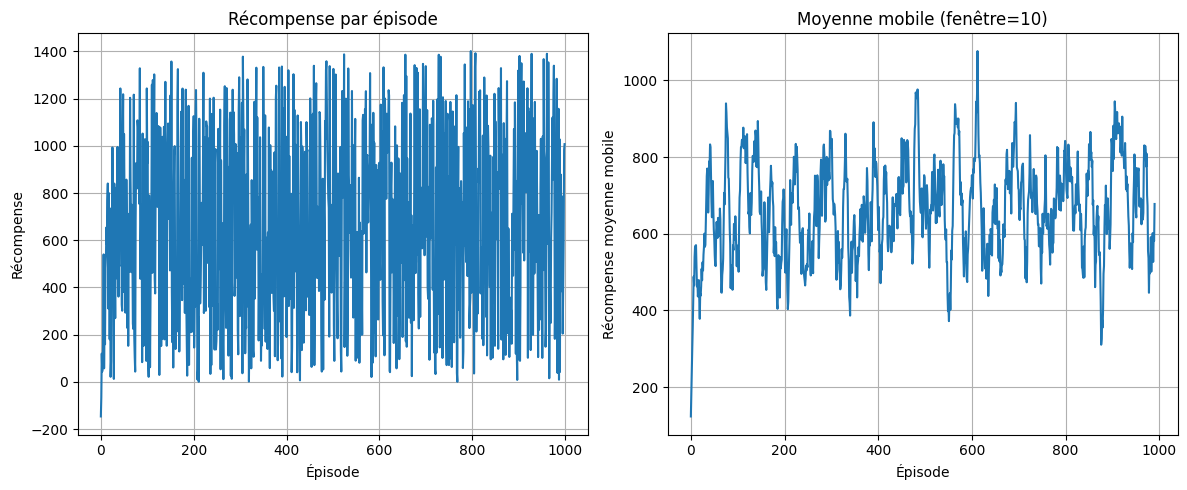


--- Test de l'agent ---
État 0 → Action choisie: 0
État 1 → Action choisie: 3
État 2 → Action choisie: 3
État 3 → Action choisie: 0
État 4 → Action choisie: 3
État 5 → Action choisie: 3
État 6 → Action choisie: 3
État 7 → Action choisie: 0
État 8 → Action choisie: 0
État 9 → Action choisie: 3


In [7]:
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ====== Chargement et préparation des données ======
df = pd.read_csv("tomato irrigation dataset.csv")

scaler = MinMaxScaler()
features = ["Temperature [C]", "Humidity [%]", "Soil moisture",
            "Reference evapotranspiration", "Evapotranspiration",
            "Crop Coefficient",
            "Nitrogen [mg/kg]", "Phosphorus [mg/kg]", "Potassium",
            "Solar Radiation ghi", "Wind Speed", "Days of planted"]
df_norm = scaler.fit_transform(df[features])
states = df_norm

# ====== Classe d'environnement ======
class TomatoIrrigationEnv(gym.Env):
    def __init__(self, states):
        super(TomatoIrrigationEnv, self).__init__()
        self.states = states
        self.n_samples = len(states)
        self.index = 0
        
        self.observation_space = spaces.Box(low=0.0, high=1.0, 
                                           shape=(states.shape[1],), 
                                           dtype=np.float32)
        self.action_space = spaces.Discrete(4)
    
    def compute_reward(self, soil_moisture, action):
        irrigation_amount = action / 3
        water_cost = 0.4 * irrigation_amount
        
        if soil_moisture < 0.5:
            reward = (soil_moisture + irrigation_amount) - water_cost
        elif soil_moisture > 0.65:
            reward = -(irrigation_amount * 2) - water_cost
        else:
            reward = 0.45 - water_cost - abs(soil_moisture - 0.57)
        
        return reward
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.index = np.random.randint(0, self.n_samples)
        return self.states[self.index], {}
    
    def step(self, action):
        state = self.states[self.index]
        soil_moisture = state[2]
        reward = self.compute_reward(soil_moisture, action)
        
        self.index += 1
        terminated = self.index >= self.n_samples
        truncated = False
        next_state = self.states[self.index % self.n_samples]
        
        return next_state, reward, terminated, truncated, {}
    
    def render(self, mode="human"):
        pass

# ====== Callback pour suivre les épisodes ======
class EpisodeCounterCallback(BaseCallback):
    def __init__(self, n_episodes, verbose=0):
        super().__init__(verbose)
        self.n_episodes = n_episodes
        self.episode_count = 0
        self.episode_rewards = []
        self.current_episode_reward = 0
        
    def _on_step(self) -> bool:
        self.current_episode_reward += self.locals['rewards'][0]
        
        if self.locals['dones'][0]:
            self.episode_count += 1
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0
            
            if self.verbose > 0:
                print(f"Épisode {self.episode_count}/{self.n_episodes} terminé. "
                      f"Récompense: {self.episode_rewards[-1]:.2f}")
            
            # Arrêter l'entraînement si le nombre d'épisodes est atteint
            if self.episode_count >= self.n_episodes:
                print(f"\n{self.n_episodes} épisodes complétés!")
                return False  # Stop training
        
        return True  # Continue training

# ====== Fonction d'entraînement avec nombre d'épisodes ======
def train_ppo_with_episodes(env, n_episodes=100, ent_coef=0.01, verbose=1):
    """
    Entraîne un agent PPO pour un nombre spécifique d'épisodes
    
    Args:
        env: L'environnement gymnasium
        n_episodes: Nombre d'épisodes d'entraînement
        ent_coef: Coefficient d'entropie pour PPO
        verbose: Niveau de verbosité
    
    Returns:
        model: Le modèle entraîné
        callback: Le callback contenant les statistiques
    """
    model = PPO("MlpPolicy", env, verbose=verbose, ent_coef=ent_coef)
    
    # Créer le callback
    episode_callback = EpisodeCounterCallback(n_episodes=n_episodes, verbose=1)
    
    # Estimer le nombre de timesteps nécessaires
    # On utilise une grande valeur, le callback s'arrêtera au bon nombre d'épisodes
    estimated_timesteps = n_episodes * env.n_samples * 2
    
    print(f"Début de l'entraînement pour {n_episodes} épisodes...")
    model.learn(total_timesteps=estimated_timesteps, callback=episode_callback)
    
    return model, episode_callback

# ====== Entraînement et visualisation ======
if __name__ == "__main__":
    env = TomatoIrrigationEnv(states)
    
    # PARAMÈTRES À AJUSTER
    N_EPISODES = 1000  # Nombre d'épisodes souhaité
    ENT_COEF = 0.1   # Coefficient d'entropie
    
    # Entraînement
    model, callback = train_ppo_with_episodes(
        env, 
        n_episodes=N_EPISODES, 
        ent_coef=ENT_COEF,
        verbose=1
    )
    
    print("\nEntraînement terminé!")
    print(f"Nombre total d'épisodes: {callback.episode_count}")
    print(f"Récompense moyenne: {np.mean(callback.episode_rewards):.2f}")
    print(f"Récompense max: {np.max(callback.episode_rewards):.2f}")
    print(f"Récompense min: {np.min(callback.episode_rewards):.2f}")
    
    # Visualisation des récompenses par épisode
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(callback.episode_rewards)
    plt.xlabel('Épisode')
    plt.ylabel('Récompense')
    plt.title('Récompense par épisode')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    window = min(10, len(callback.episode_rewards))
    if window > 1:
        moving_avg = np.convolve(callback.episode_rewards, 
                                np.ones(window)/window, 
                                mode='valid')
        plt.plot(moving_avg)
        plt.xlabel('Épisode')
        plt.ylabel('Récompense moyenne mobile')
        plt.title(f'Moyenne mobile (fenêtre={window})')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Test de l'agent entraîné
    print("\n--- Test de l'agent ---")
    obs, _ = env.reset()
    for i in range(10):
        action, _ = model.predict(obs, deterministic=True)
        print(f"État {i} → Action choisie: {action}")
        obs, reward, terminated, truncated, _ = env.step(action)
        if terminated:
            obs, _ = env.reset()
